In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# %matplotlib notebook

# Construction Zone: Building a Metropolis-Hastings Sampler From Scratch

#### Version 0.1

-----

By AA Miller (Northwestern/Adler Planetarium)

27 Aug 2019

As we just saw, Bayes' Law provides a framework for understanding/inferring model parameters *given* some observations/data:

$$P(\theta\mid\mathbf{x}) = \frac{P(\mathbf{x}\mid\theta)\;P(\theta)}{P(\mathbf{x})},$$

where we have used the short-hand notation with $\theta$ representing the model parameters, and $\mathbf{x}$ representing the data. 

To redefine some terms,

$P(\mathbf{x}\mid\theta)$, the probability of the data given the model parameters, is the *likelihood*, $\mathcal{L}$.

$P(\theta)$, the probability of the model parameters, is the *prior*.

$P(\mathbf{x})$ the probability of the data, is the *evidence*. (That sounds weird right? More on this in a bit...)

Finally, $P(\theta\mid\mathbf{x})$, the probability of the model parameters given the data, is the *posterior*, $\pi$. 

We typically want to estimate some model parameters, $\theta$, and thus we need to integrate the posterior, $P(\theta\mid\mathbf{x})$.

This is **hard**.

In particular, how in the world are we supposed to estimate the *probability of data*?!

This is – capital H – **Hard**.

(We will discuss this on Friday)

Fortunately, $P(\mathbf{x})$ simply serves as a normalization term, and, in many applications, can be ignored. 

Thus, given that the posterior is $\propto \mathcal{L}\;P(\theta)$, we can maximize the posterior by maximizing the product of the likelihood and the prior. While this still leaves a complicated integral, there are many tools that can approximate that integral rather efficiently...

including the Metropolis-Hastings algorithm!

## Problem 1) Simulate the Observations

As we work towards implementing the MH sampler, we will attempt to solve a very common problem in the statistical literature: estimating the slope and intercept of a line from noisy data.

Here we will simulate some data with known model parameters so we can later compare our estimates to the correct answer.

**Problem 1a**

Draw 40 observations between 0 and 100 from a linear model with slope, $m = 2.3$, and intercept, $b = 15$. Assume that each observation is drawn from a Gaussian distribution with mean $\mu = 0$ and variance, $\sigma^2$ = 2500.

In [3]:
np.random.seed(212)
m_true = 2.3
b_true = 15
x = np.random.uniform(low=0, high=100, size=40)
y_true = m_true * x + b_true
y_obs = y_true + np.random.normal(0,50,size=40)
y_unc = np.ones_like(y_obs)*50

**Problem 1b**

Plot the observations and the corresponding uncertainties. Overplot a line showing the model from which the data were drawn.

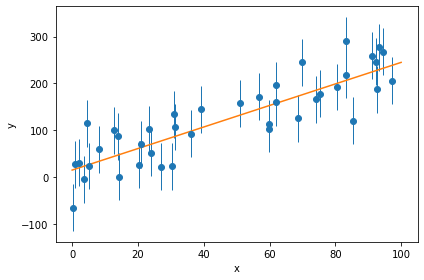

In [4]:
fig, ax = plt.subplots()

ax.errorbar(x, y_obs, yerr=y_unc, marker="o", linewidth=0, elinewidth=1)
ax.plot([0,100], b_true + m_true*np.array([0,100]))
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

**Problem 1c**

Create a function `get_model_predictions` that calculates the expected value of $\mathbf{y}$ given input parameters `theta` and positions $\mathbf{x}$.

*Hint* - store the model parameters in a tuple `theta` = (m, b). This will make life easier later.

In [5]:
def get_model_predictions(theta, x):
    '''
    Calculate the model at any position x
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    Returns
    -------
    model_preds : arr-like, shape (n_samples)
        Array of model values
    '''
    m, b = theta
    model_preds = m * x + b
    
    return model_preds

## Problem 2) The Posterior

In order to approximate the posterior we need to be able to calculate it at any point within the multidimensional parameter space. 

Assuming gaussian distributed scatter in the observations, we can describe the probability of any individual observation as a function of the model parameters:

$$p(y_i \mid m, b, x_i, \sigma_i) = \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}},$$

where $y_i$ is the $i^\mathrm{th}$ observation, $x_i$ is the corresponding indpendent position at which $y_i$ is measured, $\sigma_{y_i}$ is the uncertainty on $y_i$ (constant in this case, but that doesn't have to be the case), and $m$ and $b$ are the slope and intercept for  the line.

Assuming the observations are independent, then the probability of *all* the observations is the product of the individual probabilities (note – this is the likelihood):

$$\mathcal{L} = \prod_i p(y_i \mid m, b, x_i, \sigma_i) = \prod_i \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}}.$$

This product produces really small numbers (individual observations have typical probabilities  < 0.3), which can become numerically unstable, especially for a poor choice of model parameters. 

A trick to alleviate this issue is to work with the $\log \mathcal{L}$, which using a logarithmic identity allows us to trade a product for a sum (computationally much easier!):

$$\log \mathcal{L} = \mathcal{K} - \sum_i \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2},$$

where $\mathcal{K}$ is a constant equal to $-\frac{n}{2}\log{2\pi} - \sum_i \log{\sigma_{y_i}}$.

Mathematically, maximizing the likelihood and the log likelihood are identical, and we will leverage this for the remainder of the problem.

**Problem 2a**

Write a function `lnlikelihood` to calculate the log likelihood given input parameters `theta`, `y`, `x`, and `y_unc`.

*Hint 1* – the constant $\mathcal{K}$ is the same for any point in the parameter space. Thus it can be ignored as we only care about *relative* differences in the likelihood.

*Hint 2* – store the model parameters in a single tuple `theta` = (m, b). This will make life easier later.

In [6]:
def lnlikelihood(theta, y, x, y_unc):
    '''
    Calculate the log likelihood for a model assuming Gaussian uncertainties
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    lnl : float
        The log-likelihood of the observations given the model parameters
    '''
    model_preds = get_model_predictions(theta, x)
    
    lnl = -np.sum((y - model_preds)**2 / y_unc**2)
    
    return lnl

**Problem 2b**

Confirm your function works by estimating the log likelihood for $m = 1.5$ and $b = 50$.

Is the log likelihood higher or lower if you use the true model parameters (see **1a**)? 

Does this make sense?

In [7]:
print('ln L for m=1.5 and b=50 is: {:.4f}'.format(lnlikelihood((1.5, 50), y_obs, x, y_unc)))
print('ln L for m=2.3 and b=15 is: {:.4f}'.format(lnlikelihood((2.3, 15), y_obs, x, y_unc)))

ln L for m=1.5 and b=50 is: -41.5878
ln L for m=2.3 and b=15 is: -29.8719


*write your answer here*


The posterior requires an estimate of not just the likelihood, but also the prior. 

For this problem, how in the world do we choose the prior? 

(In practice, this can be very complicated and we will discuss this in more detail on Wednesday and Friday)

When you have little to no knowledge of the actual model parameters, it is often "safe" to assume a wide and flat prior (sometimes referred to as an uniformative prior). A wide and flat prior essentially says that any value within the bounds of the prior is equally likely, while values outside the bounds are unacceptable. 

While we know the true answer, let's pretend that we don't. From the data (technically, using the data to estimate the prior is cheating, as we'll discuss on Friday) we can see that the slope is definitely positive, and also definitely less than 300 (the largest y value in the data set). Thus, we will set a uniform prior on $m$ from 0 to 300:

$$P(m) \sim \mathcal{U}(0,300).$$

From similar arguments the intercept is likely somewhere between -100 and 100:

$$P(b) \sim \mathcal{U}(-100,100).$$


**Problem 2c**

Write a function `lnprior` to calculate the log of the prior from an input tuple of the model parameters `theta`.

*Hint* - while the $\log{0}$ is undefined, have the function return `-np.inf` for values outside the bounds of the prior.

In [8]:
def lnprior(theta):
    '''
    Calculate the log of the prior for the model parameters
    
    Parameters
    ----------
    theta : tuple
        Model parameters
            
    Returns
    -------
    lnp : float
        The log-prior of the model parameters
    '''
    m, b = theta
    if 0 <= m <= 300 and -100 <= b <= 100:
        lnp = np.log(1/300) + np.log(1/200) # assumes P(m) and P(y) are completely independent
    else:
        lnp = -np.inf
    
    return lnp

**Problem 2d**

Calculate the prior for $(m, b) = (1, 0)$, $(2.3, 15)$, $(3, -150)$, and $(-1, 90)$.

Do your answers make sense?

In [9]:
print('ln P for m=1.0 and b=0 is: {:.4f}'.format(lnprior((1, 0))))
print('ln P for m=2.3 and b=15 is: {:.4f}'.format(lnprior((2.3, 15))))
print('ln P for m=3 and b=-150 is: {:.4f}'.format(lnprior((3, -150))))
print('ln P for m=-1 and b=90 is: {:.4f}'.format(lnprior((-1, 90))))

ln P for m=1.0 and b=0 is: -11.0021
ln P for m=2.3 and b=15 is: -11.0021
ln P for m=3 and b=-150 is: -inf
ln P for m=-1 and b=90 is: -inf


*write your answer here*


**Problem 2e**

Write a function `lnposterior` to calculate the log of the posterior.

*Hint* - this is straightforward using functions you have already written.

In [10]:
def lnposterior(theta, y, x, y_unc):
    '''
    Calculate the log posterior
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    lnpost : float
        The log-posterior from the observations and model parameters
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlikelihood(theta, y, x, y_unc)
    lnpost = lnp + lnl
        
    return lnpost

**Problem 2f**

What is the log posterior for $m = 1.5$ and $b = 50$?

What is the log posterior for $m = 2.3$ and $b = 15$?

What is the log posterior for $m = 1.5$ and $b = 200$?

Does this make sense?

In [11]:
print('ln posterior for m=1.5 and b=50 is: {:.4f}'.format(lnposterior((1.5, 50), y_obs, x, y_unc)))
print('ln posterior for m=2.3 and b=15 is: {:.4f}'.format(lnposterior((2.3, 15), y_obs, x, y_unc)))
print('ln posterior for m=1.5 and b=200 is: {:.4f}'.format(lnposterior((1.5, 200), y_obs, x, y_unc)))


ln posterior for m=1.5 and b=50 is: -52.5899
ln posterior for m=2.3 and b=15 is: -40.8740
ln posterior for m=1.5 and b=200 is: -inf


*write your answer here*


## Problem 3) The Metropolis-Hastings Algorithm

The [Metropolis-Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) (MH) is the most simple [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) ([MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)) procedure for estimating Bayesian posteriors. 

We will cover the nitty gritty (i.e., mathematics) of how MCMC works tomorrow. For now, we will focus on Metropolis-Hastings as an algorithm, and assume it works.  

The pseudo-code for the MH algorithm is:

0. pick some position $\theta_0$ in the parameter space and calculate the posterior $P(\theta_{0}\mid \mathbf{x})$
1. begin the chain
    - "propose" a move from the current position $\theta_{i}$ to a new position $\theta_{i+1}$
    - calculate the posterior at $\theta_{i+1}$, $P(\theta_{i+1}\mid \mathbf{x})$
    - draw a random number, $R \sim \mathcal{U}(0,1)$
    - if the ratio $P(\theta_{i+1}\mid \mathbf{x})/P(\theta_{i}\mid \mathbf{x})$ is $> R$, "accept" the proposed move and advance the chain to $\theta_{i+1}$
    - else "reject" the proposal and set $\theta_{i+1} = \theta_{i}$

2. repeat until chain is "finished"

A few subtleties worth noting: the use of the random number is essential for allowing the MH algorithm to "explore" the full posterior. It's actually possible to add links to the chain that are less probable than the current position. This is an important distinction relative to optimization routines that simply identify local maxima, but only progressing in the direction of increased probability.

Also "finished" isn't really defined - we will cover this tomorrow.

An extra subtle point: technically you need to calculate the full Hastings ratio, $H$, when evaluating whether or not to accept or reject a proposal:

$$H = \frac{\pi(\theta_{i+1})}{\pi(\theta_{i})} \frac{q(\theta_i \mid \theta_{i+1})}{q(\theta_{i+1} \mid \theta_{i})},$$

where $q(\theta_i \mid \theta_{i+1})/q(\theta_{i+1} \mid \theta_{i})$ is the ratio of transition probabilities from $\theta_{i+1}$ to $\theta_{i}$ and back again. 

Fortunately, most proposals are symmetric, including what we will implement, meaning the ratio of transition probabilities is 1, and thus, this term can be safely ignored.

**Problem 3a**

Write a function `hastings_ratio` to calculate the ratio of log-posterior values at `theta_1` relative to `theta_0`.

*Hint* – assume the ratio of transition probabilities is 1.

In [12]:
def hastings_ratio(theta_1, theta_0, y, x, y_unc):
    '''
    Calculate the Hastings ratio
    
    Parameters
    ----------
    theta_1 : tuple
        proposed new posterior position 
    
    theta_0 : tuple
        current posterior position
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    h_ratio : float
        The Hastings ratio
    '''
    lnpost1 = lnposterior(theta_1, y, x, y_unc)
    lnpost0 = lnposterior(theta_0, y, x, y_unc)
    
    h_ratio = np.exp(lnpost1) / np.exp(lnpost0)
    
    return h_ratio

**Problem 3b**

Calculate the Hastings ratio to move from $(2.1, 50)$ to $(2.2,30)$.

How often would the algorithm accept this step?

In [13]:
print('The Hastings ratio is: {:.4f}'.format(hastings_ratio((2.2, 30), (2.1, 50), y_obs, x, y_unc)))

The Hastings ratio is: 3112.2012


*write your answer here*

In this case $H > 1$, and thus this proposed move  would be accepted every time.

**Problem 3c** 

What about the reverse proposal? Calculate the Hastings ratio to move from (2.2, 30) to (2.1, 50). 

On average, how many times would such a proposal need to be made to be accepted by the MH algortihm?

In [14]:
print('The Hastings ratio is: {:.4f}'.format(hastings_ratio((2.1, 50), (2.2, 30), y_obs, x, y_unc)))

The Hastings ratio is: 0.0003


*write your answer here*


As we will show below, the difference between an MCMC chain that takes forever and one that samples the posterior "quickly" is largely a function of the proposal distribution. 

We want a symmetric proposal to ensure the transition ratio is equal to 1. The easiest way to accomplish this is with a normal distribution centered at the current position in the posterior, with a user-defined covariance matrix. (Today we will assume the covariance matrix is  diagonal).

**Problem 3d**

Write a function `propose_jump` that creates new proposal positions for the MCMC chain, based on its current position, `theta`, and a covariance matrix, `cov`, for the multivariate normal distribution centered on `theta`.

*Hint 1* - allow `cov` to be either 1-D with standard deviations as the input, in which case the entries are converted to a diagonal matrix, or 2-D, where the full covariance matrix is specified.

*Hint 2* - you may find [`numpy.random.multivariate_normal`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.multivariate_normal.html) helpful.

In [15]:
def propose_jump(theta, cov):
    '''
    Generate a proposed new position for MCMC chain
    
    Parameters
    ----------
    theta : 1-D array_like, of length N
        current position of the MCMC chain
    
    cov : 1-D or 2-D array_like, of shape (N,) or (N, N)
        Covariance matrix of the distribution. It must be symmetric 
        and positive-semidefinite for proper sampling.
        
        1-D inputs for cov require the standard deviation along 
        each axis of the N-dimensional Gaussian.

    
    Returns
    -------
    proposed_position : 1-D array_like, of length N
    '''
    if np.shape(theta) == np.shape(cov):
        cov = np.diag(np.array(cov)**2)
    
    proposed_position = np.random.multivariate_normal(theta, cov)
    
    return proposed_position

**Problem 3e**

Propose 5 random steps from the position $(m, b) = (2, 45)$, and calculate the Hastings ratio for each of the 5 proposals. Use a standard deviation of 1 along both axes of the multivariate normal distribution.

Do you notice anything interesting about your results?

In [16]:
theta_0 = (2,45)
for _ in range(5):
    new_pos = propose_jump(theta_0, (1,1))
    H = hastings_ratio(new_pos, theta_0, y_obs, x, y_unc)
    print('Jumping to {}, gives H = {:.4f}'.format(new_pos, H))

Jumping to [ 0.45943062 45.90438492], gives H = 0.0000
Jumping to [ 2.20180364 43.40090323], gives H = 0.0591
Jumping to [ 2.94586254 45.65810275], gives H = 0.0000
Jumping to [ 2.16080705 45.18664474], gives H = 0.0536
Jumping to [ 3.67912415 43.98313865], gives H = 0.0000


*write your answer here*


**Problem 3f**

Repeat **3e** but this time use a standard deviation of 0.1 for the slope and 10 for intercept.

Are the results substantially different?

In [17]:
theta_0 = (2,45)
for _ in range(5):
    new_pos = propose_jump(theta_0, (0.1,10))
    H = hastings_ratio(new_pos, theta_0, y_obs, x, y_unc)
    print('Jumping to {}, gives H = {:.4f}'.format(new_pos, H))

Jumping to [ 1.90501148 59.09075624], gives H = 0.0012
Jumping to [ 1.90921755 40.35253635], gives H = 3.9294
Jumping to [ 2.05432445 52.63885156], gives H = 0.0044
Jumping to [ 2.09992419 49.11959898], gives H = 0.0174
Jumping to [ 1.91830748 30.89622717], gives H = 4.1531


*write your answer here*

The Hastings ratios are now much larger. It is clear that the width of the multivariate normal along each axis will affect the efficiency of the MH sampler.

Referring back to the pseudo code above, we now have all the ingredients necessary to put together a MH sampler. We just need to stitch everything together so that we actually form a chain.

**Problem 3g**

Write a function `mh_mcmc` that takes an initial position `theta_0`, covariance matrix for the multivariate normal proposal distribution `cov`, total number of steps `nsteps`, and observations `y`, `x`, and `y_unc` as inputs and returns the Metropolis-Hastings chain for the given inputs.

The output "chain" should include the position of the chain within the parameter space, the log of the posterior at that position, and the "acceptance ratio" of the chain until that point. The acceptance ratio is the fraction of previously proposed steps (including the current proposal) that have been accepted. We will come back to this later.

In [18]:
def mh_mcmc(theta_0, cov, nsteps, y, x, y_unc):
    '''
    Metropolis-Hastings MCMC algorithm
    
    Parameters
    ----------
    theta_0 : 1-D array_like of shape N
        starting position for the MCMC chain
    
    cov : 1-D or 2-D array_like, of shape (N,) or (N, N)
        Covariance matrix of the distribution. It must be symmetric 
        and positive-semidefinite for proper sampling.
        
        1-D inputs for cov require the standard deviation along 
        each axis of the N-dimensional Gaussian.

    nsteps : int
        Number of steps to take in the MCMC chain
        
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    (positions, lnpost_at_pos, acceptance_ratio) : tuple
        positions : 2-D array_like of shape (nsteps+1, N)
            Position of the MCMC chain at every step
        
        lnpost_at_pos : 1-D array_like of shape nsteps+1
            log-posterior value at the position of the MCMC chain
        
        acceptance_ratio : 1-D array_like of shape nsteps+1
            acceptance ratio of all previous steps in the chain    
    '''
    
    positions = np.zeros((nsteps+1, len(theta_0)))
    lnpost_at_pos = -np.inf*np.ones(nsteps+1)
    acceptance_ratio = np.zeros_like(lnpost_at_pos)
    accepted = 0
    
    positions[0] = theta_0
    lnpost_at_pos[0] = lnposterior(theta_0, y, x, y_unc)
    
    for i in range(1, nsteps+1):
        proposal = propose_jump(positions[i-1], cov)
        H = hastings_ratio(proposal, positions[i-1], y, x, y_unc)
        R = np.random.uniform()
        
        if H > R:
            positions[i] = proposal
            lnpost_at_pos[i] = lnposterior(proposal, y, x, y_unc)
            accepted += 1
            acceptance_ratio[i] = float(accepted) / i
        else:
            positions[i] = positions[i-1]
            lnpost_at_pos[i] = lnpost_at_pos[i-1]
            acceptance_ratio[i] = float(accepted) / i    
    
    return (positions, lnpost_at_pos, acceptance_ratio)

**Problem 3h**

Run the MH sampler! 

Using a starting point of $(m, b) = (2.7, -70)$ (this is estimated from the two most extreme points in the dataset), `cov = (0.25, 5)`, and run the chain for 500 steps.

In [19]:
pos, lnpost, acc = mh_mcmc((2.7,-70), (0.25, 5), 500, y_obs, x, y_unc)

**Problem 3i**

Plot the positions of the chain in the $(m, b)$ plane. Overplot the true answer as a five-pointed star.

Does your plot "make sense"?

*Hint* – connect the points with line segments so you can visualize its evolution. 

*Hint 2* – set `alpha = 0.4` to get a sense of positions where multiple proposals were required for the chain to move.

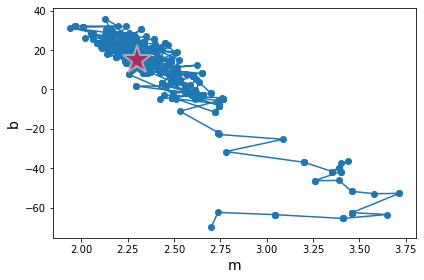

In [20]:
fig, ax = plt.subplots()
ax.plot(pos[:, 0], pos[:, 1], "o-")
ax.plot(2.3, 15, 
        '*', ms=30, 
        mfc='Crimson', mec='0.8', mew=2, 
        alpha=0.7)
ax.set_xlabel('m', fontsize=14)
ax.set_ylabel('b', fontsize=14)
fig.tight_layout()

**Problem 3j**

Recreate the above plot, but this time color code the individual points by the value of the log posterior at each position.

*Hint* –– you will want to use [`pyplot.scatter`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html)

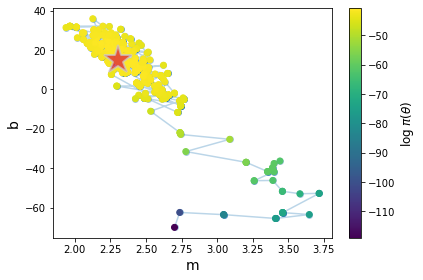

In [21]:
fig, ax = plt.subplots()
ax.plot(pos[:,0], pos[:,1], 'o-', alpha=0.3)
cax = ax.scatter(pos[:, 0], pos[:, 1], c=lnpost, zorder=10)
ax.plot(2.3, 15, 
        '*', ms=30, 
        mfc='Crimson', mec='0.8', mew=2, 
        alpha=0.7, zorder=20)
ax.set_xlabel('m', fontsize=14)
ax.set_ylabel('b', fontsize=14)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel(r'$\log \; \pi (\theta)$', fontsize=12)
fig.tight_layout()

Awesome! 

You are now tooled up to solve any Bayesian problem that you might encounter.

## Problem 4) Optimizing MH

While you are now, no doubt, wildly excited about what you have accomplished in $\sim{90}$ min time, there should be a few things that bother you. In particular, there were several "hard coded" options in the previous problem. 

#### Weird Choice #1

Why 500 steps? 

It's clear from **3i** that ~10-20 steps is no where near enough, as the chain does not sample the maximum of the posterior. But is 500 steps too many? Or is it not enough?

(There are mathematical ways to judge this, which we will cover tomorrow)

#### Weird Choice #2

Why `(0.2, 10)` for the widths of the multivariate normal proposal function?

Previously we argued that it's possible to take steps that are too large, but is it also possible the steps are too small?

(Technically, as we will see tomorrow, the step size does not matter as all MCMC chains will eventually eplore the full posterior within an infinite number of steps, but who amoung us can wait infinity seconds to learn the slope of this line?)

#### Weird Choice #3

Why did we start the chain at (2.7,-70)?

(Again, technically this does not matter, but do you want to wait for an infinite number of steps before getting the results?)

Tommorrow we will formalize all of these choices, for now we will try to develop some intuition via some graphical examples.

**Problem 4a**

Write a function `plot_post` that recreates the plots from **3i** and **3j** side by side given inputs 
`theta_0`, `cov`, `nsteps`, `y`, `x`, and `y_unc`.

In [22]:
def plot_post(theta_0, cov, nsteps, y, x, y_unc):
    '''
    Plot posterior trace from MH MCMC
    
    Parameters
    ----------
    theta_0 : 1-D array_like of shape N
        starting position for the MCMC chain
    
    cov : 1-D or 2-D array_like, of shape (N,) or (N, N)
        Covariance matrix of the distribution. It must be symmetric 
        and positive-semidefinite for proper sampling.
        
        1-D inputs for cov require the standard deviation along 
        each axis of the N-dimensional Gaussian.

    nsteps : int
        Number of steps to take in the MCMC chain
        
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
    '''
    
    pos, lnpost, acc = mh_mcmc(theta_0, cov, nsteps, y_obs, x, y_unc)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax0.plot(pos[:nsteps, 0], pos[:nsteps, 1], "o-")
    ax0.plot(2.3, 15, 
            '*', ms=30, 
            mfc='Crimson', mec='0.8', mew=2, 
            alpha=0.7)
    ax0.set_xlabel('m', fontsize=14)
    ax0.set_ylabel('b', fontsize=14)

    ax1.plot(pos[:nsteps, 0], pos[:nsteps, 1], 'o-', alpha=0.3)
    cax1 = ax1.scatter(pos[:nsteps, 0], pos[:nsteps, 1], c=lnpost[:nsteps], zorder=10)
    ax1.plot(2.3, 15, 
            '*', ms=30, 
            mfc='Crimson', mec='0.8', mew=2, 
            alpha=0.7, zorder=20)
    ax1.set_xlabel('m', fontsize=14)
    ax1.set_ylabel('b', fontsize=14)
    cbar = fig.colorbar(cax1)
    cbar.ax.set_ylabel(r'$\log \; \pi (\theta)$', fontsize=12)
    
    return

**Problem 4b**

Plot the MH chain using `theta_0 = (2.7, -70)`, `cov = (0.25, 5)`, for 50 steps.

Do the same for a chain with 5000 steps.

What changes do you notice as you vary the number of steps?

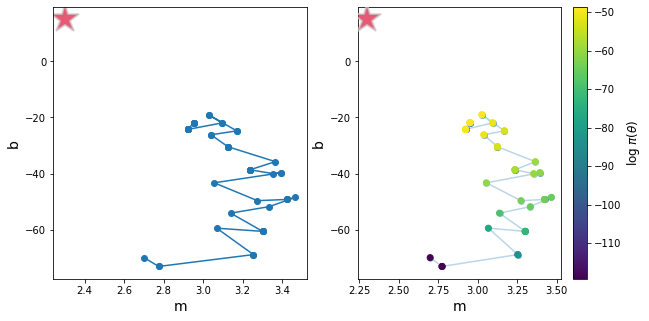

In [23]:
# 50 step plot
plot_post((2.7, -70), (0.25, 5), 50, y_obs, x, y_unc)

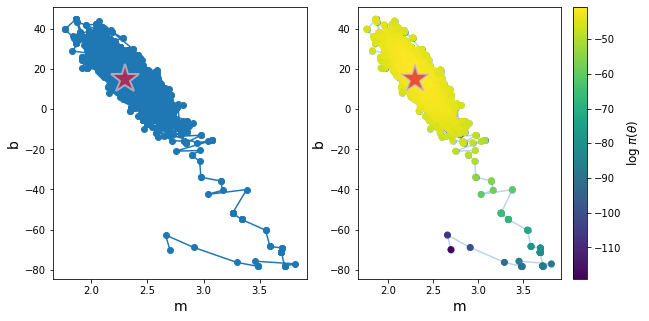

In [24]:
# 5000 step plot
plot_post((2.7, -70), (0.25, 5), 5000, y_obs, x, y_unc)

*write your answer here*



**Problem 4b**

Plot the MH chain using `theta_0 = (2.7, -70)`, `cov = (.025, .5)`, for 500 steps.

Do the same for `cov = (2.5, 50)`.

What changes do you notice as you vary the size of the proposal distribution?

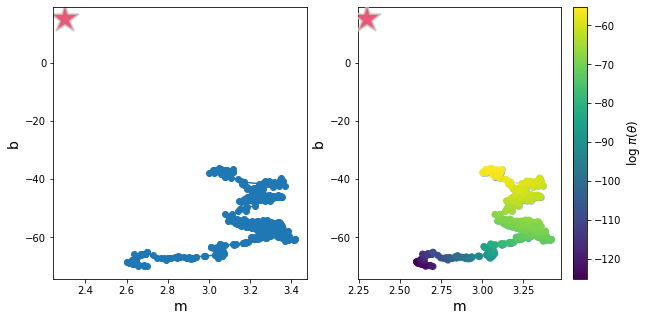

In [25]:
# cov = (0.025, .5) plot
plot_post((2.7, -70), (0.025, 0.5), 500, y_obs, x, y_unc)

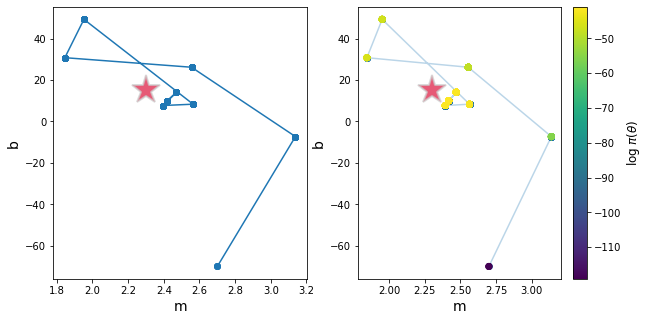

In [26]:
# cov = (2.5, 50) plot
plot_post((2.7, -70), (2.5, 50), 500, y_obs, x, y_unc)

*write your answer here*


**Problem 4c**

Plot the MH chain using `theta_0 = (27, -100)`, `cov = (.25, 5)`, for 500 steps.

Do the same for `theta_0 = (.27, -7)`.

What changes do you notice as you vary the starting position of the chain?

<ipython-input-12-aa322365d161>:30: RuntimeWarning: invalid value encountered in double_scalars
  h_ratio = np.exp(lnpost1) / np.exp(lnpost0)


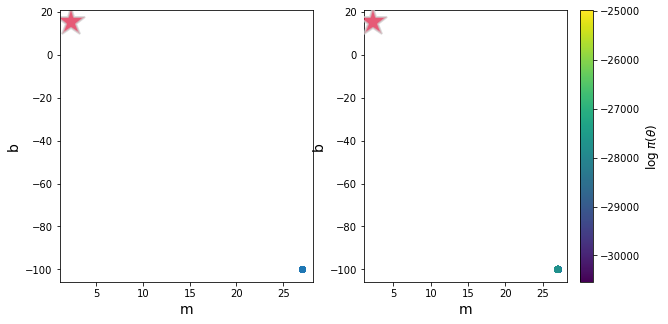

In [27]:
# theta_0 = (27, -100) plot
plot_post((27, -100), (0.25, 5), 500, y_obs, x, y_unc)

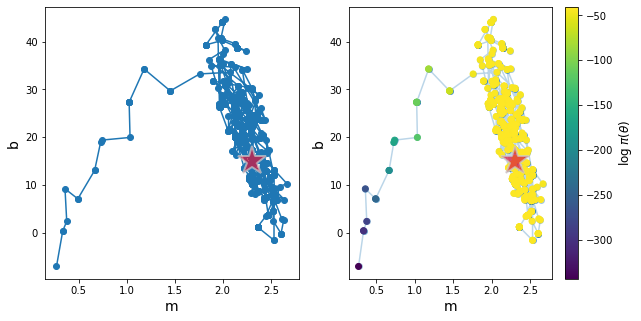

In [28]:
# theta_0 = (.27, -7) plot
plot_post((0.27, -7), (0.25, 5), 500, y_obs, x, y_unc)

*write your answer here*


When evaluating MCMC chains, there are many different diagnostic plots that are helpful for that purpose. 

Below is a helper function that overplots draws from the posterior on top of the observations, an estimate of the posterior, and the 1-d chains for $m$, $b$, $\log \pi$, and the acceptance rate.

In [29]:
def plot_mh_summary(theta_0, cov, nsteps, y, x, y_unc):
    '''
    Plot the posterior, draws from the posterior, and 1-d chains
    
    Parameters
    ----------
    theta_0 : 1-D array_like of shape N
        starting position for the MCMC chain
    
    cov : 1-D or 2-D array_like, of shape (N,) or (N, N)
        Covariance matrix of the distribution. It must be symmetric 
        and positive-semidefinite for proper sampling.
        
        1-D inputs for cov require the standard deviation along 
        each axis of the N-dimensional Gaussian.

    nsteps : int
        Number of steps to take in the MCMC chain
        
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
    '''
    pos, lnpost, acc = mh_mcmc(theta_0, cov, nsteps, y_obs, x, y_unc)

    fig = plt.figure(figsize=(7.5,6))
    ax1 = plt.subplot2grid((4,5), (0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((4,5), (2, 0), colspan=2, rowspan=2)
    ax3 = plt.subplot2grid((4,5), (0, 2), colspan=3)
    ax4 = plt.subplot2grid((4,5), (1, 2), colspan=3, sharex=ax3)
    ax5 = plt.subplot2grid((4,5), (2, 2), colspan=3, sharex=ax3)
    ax6 = plt.subplot2grid((4,5), (3, 2), colspan=3, sharex=ax3)

    # posterior
    ax1.hexbin(pos[:,0], pos[:,1], gridsize=50, mincnt=1, bins='log')
    ax1.plot(2.3, 15, '*', ms=30, 
        mfc='Crimson', mec='0.8', mew=2, 
        alpha=0.7)
    ylims = ax1.get_ylim()
    xlims = ax1.get_xlim()
    ax1.plot([2.3, 2.3], ylims, 'Crimson', alpha=0.3)
    ax1.plot(xlims, [15, 15], 'Crimson', alpha=0.3)
    ax1.set_ylim(ylims)
    ax1.set_xlim(xlims)
    ax1.set_xlabel('m')
    ax1.set_ylabel('b')
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.tick_params(top=True, bottom=False)
    
    # posterior draws
    ax2.errorbar(x, y_obs, y_unc, fmt='o')
#     ax2.plot([0,100], 
#              b_true + m_true*np.array([0,100]),
#              '--', color='DarkOrange', lw=2, zorder=-10)
    for draw in np.random.choice(len(pos), 10, replace=False):
        ax2.plot([0,100], pos[draw,1] + pos[draw,0]*np.array([0,100]),
                 'DarkOrange', alpha=0.4)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    ax3.plot(pos[:,0])
    ax3.set_ylabel('m')
    
    ax4.plot(pos[:,1])
    ax4.set_ylabel('b')

    ax5.plot(lnpost)
    ax5.set_ylabel('$\ln \; \pi$')

    ax6.plot(acc)
    ax6.set_ylabel('acceptance')
    ax6.set_xlabel('step number')
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.setp(ax5.get_xticklabels(), visible=False)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.93, left=0.09, right=0.99, hspace=0.07, wspace=0.75)

**Problem 4d**

Create a summary plot using our "default" parameters of `theta_0 = (2.7, -70)`, `cov = (0.25, 5)`, and 500 steps.

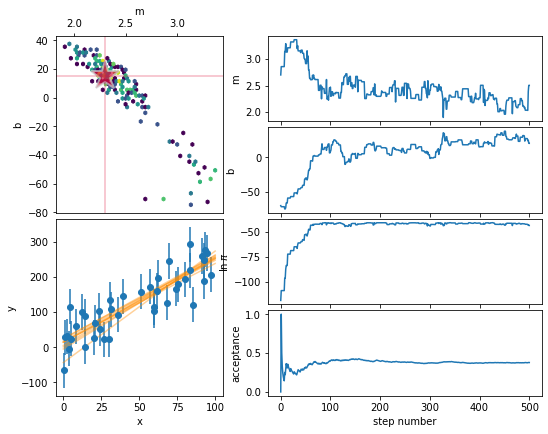

In [30]:
plot_mh_summary((2.7, -70), (0.25, 5), 500, y_obs, x, y_unc)

Without proof, I will state that we are looking for the following as we diagnose our MCMC:

1. dense sampling of the high probability portion of the posterior
2. draws from the posterior that are mostly consistent with the data
3. trace plots for m and b that are roughly i.i.d. (and do not show significant structure)
4. log posterior values that oscillate around the maximum with variations no larger than a few
5. a stable acceptance ratio of ~0.5 (note for simple problems 0.5 is good, for complex posteriors 0.25 is more likely)

**Problem 4e**

Vary the MH MCMC parameters to "better" sample the posterior according to the criteria given above. 

*Hint* – this will likely take a lot of trial and error.

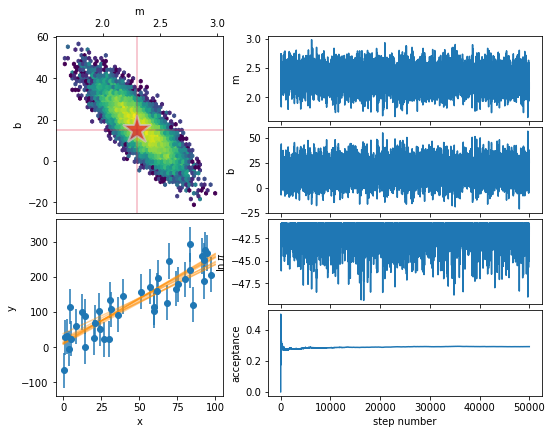

In [31]:
plot_mh_summary((2.3, 15), (0.23, 13), 50000, y_obs, x, y_unc)

## Challenge Problem) Inference & Forecasting

**Challenge 1a**

Based on your solution to the previous problem, what do you estimate is the value of $m$ and $b$? 

What are the marginalized 90% credible regions for these paramters? How does this compare to the true answer?

In [32]:
pos, lnpost, acc = mh_mcmc((2.3, 15), (23, 13), 50000, y_obs, x, y_unc)

print('m = {0[0]:.3f} with a 90% credible region from {0[1]:.3f} to {0[2]:.3f}'.format(np.percentile(pos[:, 0], [50, 5, 95])))
print('b = {0[0]:.3f} with a 90% credible region from {0[1]:.3f} to {0[2]:.3f}'.format(np.percentile(pos[:, 1], [50, 5, 95])))

m = 2.333 with a 90% credible region from 1.999 to 2.646
b = 14.465 with a 90% credible region from -1.651 to 35.121


**Challenge 1b**

How does your answer compare to the maximum-likelihood method? Estimate the values of $m$ and $b$ using [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html).

*Hint* –– you'll want to minimize the *negative* log likelihood, in order to estimate the optimal parameters for the model.

In [33]:
from scipy.optimize import minimize

nll = lambda *x: -lnlikelihood(*x)

result = minimize(nll, [2.3, 15], args=(y_obs, x, y_unc))

print('m, b = {0[0]:.4f}, {0[1]:.4f}'.format(result.x))
print('with sigma ~ {0[0]:.4f}, {0[1]:.4f}'.format(np.diag(result.hess_inv)**0.5))

m, b = 2.3218, 16.6655
with sigma ~ 0.1722, 9.8447


**Challenge 1c**

Based on your solutions above, what do you estimate is the value of y at x = 50?

What is the 90% credible region for this prediction?

In [34]:
y_pred = np.zeros_like(pos)
for i, theta in enumerate(pos):
    y_pred[i] = get_model_predictions(theta, 50)

print('y = {0[0]:.3f} with a 90% credible region from {0[1]:.3f} to {0[2]:.3f}'.format(np.percentile(y_pred[:, 0], [50, 5, 95])))

y = 131.856 with a 90% credible region from 122.818 to 141.442


## Challenge Problem 2) Gibbs Sampler

The [Gibbs sampler](https://en.wikipedia.org/wiki/Gibbs_sampling) is a special case of the Metropolis-Hastings sampler.

Alter the Metropolis-Hastings algorithm that you have created to act as a Gibbs sampler. 

In [35]:
# complete